Menggunakan device: mps
Konfigurasi Eksperimen: E=5000, S=100, IC/BC=100, Runs=20
Menghitung solusi referensi FDM (2001x50001)...
FDM Selesai dalam 66.09 detik. Mulai PINN Eksperimen...

--- Starting Method: MC on mps (N_EPOCHS=5000, N_SAMPLES=100, W_RES=50.0) ---
Run 1/20 finished. Loss: 1.666e-01, MSE: 1.115e-03, Time: 53.19s (Best Model Saved)
Run 2/20 finished. Loss: 1.635e-01, MSE: 9.107e-05, Time: 49.66s (Best Model Saved)
Run 3/20 finished. Loss: 1.453e-01, MSE: 2.091e-04, Time: 49.42s 
Run 4/20 finished. Loss: 1.668e-01, MSE: 1.233e-04, Time: 49.54s 
Run 5/20 finished. Loss: 1.655e-01, MSE: 1.369e-03, Time: 50.00s 
Run 6/20 finished. Loss: 1.827e-01, MSE: 1.555e-03, Time: 49.49s 
Run 7/20 finished. Loss: 1.762e-01, MSE: 2.731e-04, Time: 49.38s 
Run 8/20 finished. Loss: 1.519e-01, MSE: 3.660e-04, Time: 49.49s 
Run 9/20 finished. Loss: 1.571e-01, MSE: 1.552e-04, Time: 49.23s 
Run 10/20 finished. Loss: 1.638e-01, MSE: 2.716e-04, Time: 49.98s 
Run 11/20 finished. Loss: 1.739e-01, M

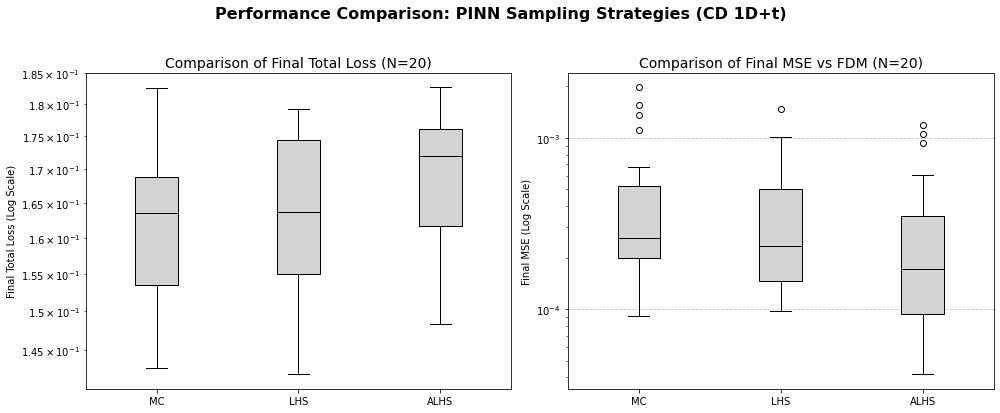

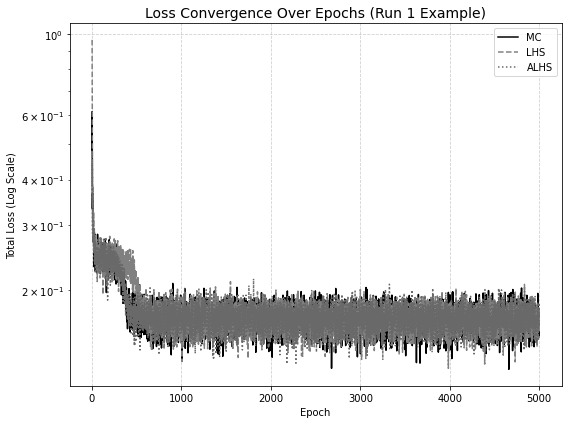


--- Generating Comparison Solution Plot (u(x, t=1.0)) ---


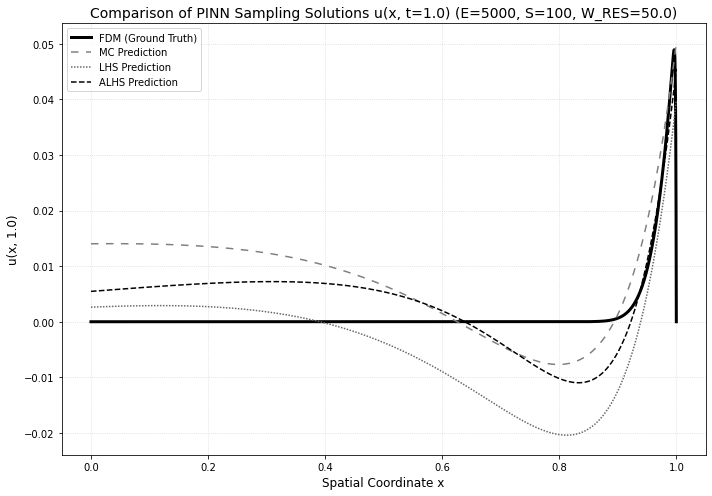

In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
from scipy.stats import qmc
from typing import Tuple, Dict, List, Any
import matplotlib.pyplot as plt

# --- 0. Konfigurasi Global dan Device ---

# Inisialisasi Device Prioritas MPS > CUDA > CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# --- Konfigurasi Eksperimen Default (Untuk Visualisasi Kualitatif) ---
N_RUNS = 20 # Diubah dari 1 (sebelumnya) menjadi 3 agar Box Plot tetap informatif
N_EPOCHS = 5000 
N_SAMPLES = 100    # Sampel Residual (domain interior) per epoch
N_IC_BC = 100      # Sampel untuk IC dan BC per epoch (PENTING: Di-match dengan N_SAMPLES)

# Parameter Persamaan Konveksi-Difusi
C_PARAM = 1.0     # Kecepatan Konveksi
D_PARAM = 0.001   # Koefisien Difusi (Masalah Boundary Layer)

# Pembobotan Loss (Strategi Eksperimen: Lambda_res = 10/50)
W_RES = 50.0
W_IC = 1.0
W_BC = 1.0

# Domain
DOMAIN_X = [0.0, 1.0]
DOMAIN_T = [0.0, 1.0]

# --- 1. Fungsi FDM Implisit (Ground Truth) ---

def solve_convection_diffusion_fdm(L=1.0, T=1.0, nx=2001, nt=50001, c=1.0, D=0.001) -> Tuple[np.ndarray, np.ndarray]:
    """Menghitung solusi referensi FDM Implisit pada t=T."""
    dx = L / (nx - 1)
    dt = T / (nt - 1)
    
    C1 = (c * dt) / (2 * dx)
    C2 = (D * dt) / (dx**2)
    
    # Koefisien Matriks Tridiagonal (Konstan)
    A = - (C1 + C2)
    B = 1 + (2 * C2)
    C_mat = C1 - C2
    
    # Kondisi Awal (IC)
    x = np.linspace(0, L, nx)
    u = np.sin(np.pi * x)
    
    n_interior = nx - 2
    
    # Loop Waktu (Time-Stepping)
    for k in range(1, nt):
        d = np.copy(u[1:-1]) # RHS
        
        # Penyesuaian RHS untuk BC Homogen (tidak ada pengaruh di sini karena u[0]=u[-1]=0)

        p = np.zeros(n_interior)
        q = np.zeros(n_interior)
        
        # TDMA Forward sweep
        p[0] = C_mat / B
        q[0] = d[0] / B
        
        for i in range(1, n_interior):
            den = B - A * p[i-1]
            p[i] = C_mat / den
            q[i] = (d[i] - A * q[i-1]) / den
            
        # TDMA Backward substitution
        u_next_interior = np.zeros(n_interior)
        u_next_interior[-1] = q[-1] 
        
        for i in range(n_interior - 2, -1, -1):
            u_next_interior[i] = q[i] - p[i] * u_next_interior[i+1]
            
        u[1:-1] = u_next_interior
        u[0] = 0.0 # BC
        u[-1] = 0.0 # BC
        
    return x, u 

# --- 2. PINN Model dan Fungsi Sampling Statis/Batas ---

class PINN(nn.Module):
    def __init__(self, layers=[2, 64, 64, 64, 1]):
        super().__init__()
        self.layers = []
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                self.layers.append(nn.Tanh())
        self.net = nn.Sequential(*self.layers).to(device)

    def forward(self, x):
        return self.net(x)

def sample_lhs_2d(n_samples: int, x_min, x_max, t_min, t_max) -> np.ndarray:
    sampler = qmc.Halton(d=2)
    pts = sampler.random(n=n_samples) 
    x_pts = x_min + pts[:, 0] * (x_max - x_min)
    t_pts = t_min + pts[:, 1] * (t_max - t_min)
    return np.hstack([x_pts.reshape(-1,1), t_pts.reshape(-1,1)])

def sample_mc_2d(n_samples: int, x_min, x_max, t_min, t_max) -> np.ndarray:
    x_pts = np.random.uniform(x_min, x_max, n_samples).reshape(-1, 1)
    t_pts = np.random.uniform(t_min, t_max, n_samples).reshape(-1, 1)
    return np.hstack([x_pts, t_pts])

def sample_ic(n_samples: int, x_min, x_max) -> np.ndarray:
    x_pts = np.random.uniform(x_min, x_max, n_samples).reshape(-1, 1)
    t_pts = np.zeros_like(x_pts) 
    return np.hstack([x_pts, t_pts])

def sample_bc(n_samples: int, t_min, t_max) -> np.ndarray:
    n_half = n_samples // 2
    t_pts = np.random.uniform(t_min, t_max, n_samples).reshape(-1, 1)
    
    x_left = np.zeros((n_half, 1))
    t_left = t_pts[:n_half]
    
    x_right = np.ones((n_samples - n_half, 1))
    t_right = t_pts[n_half:]
    
    return np.vstack([np.hstack([x_left, t_left]), np.hstack([x_right, t_right])])

# --- 3. Fungsi Residual dan Adaptive Sampler ---

def residual_CD(model: nn.Module, xt_tensor: torch.Tensor, c_param: float, D_param: float) -> torch.Tensor:
    xt = xt_tensor.clone().detach().requires_grad_(True).to(device)
    
    u = model(xt)
    
    # Turunan Orde Pertama
    grads = torch.autograd.grad(u, xt, torch.ones_like(u), create_graph=True)[0]
    u_x = grads[:, 0]
    u_t = grads[:, 1]
    
    # Turunan Orde Kedua
    u_xx = torch.autograd.grad(u_x, xt, torch.ones_like(u_x), create_graph=True)[0][:, 0]
    
    # Hitung Residual R = u_t + c * u_x - D * u_xx
    res = u_t.view(-1, 1) + c_param * u_x.view(-1, 1) - D_param * u_xx.view(-1, 1)
    return res

class AdaptiveSampler:
    def __init__(self, x_domain, t_domain, alpha=2.0, global_frac=0.6, adapt_interval=20, n_candidate=800):
        self.x_domain = x_domain
        self.t_domain = t_domain
        self.alpha = alpha
        self.global_frac = global_frac
        self.adapt_interval = adapt_interval
        self.n_candidate = n_candidate
        
        # PENTING: Unpacking di sini BENAR karena x_domain dan t_domain adalah list [min, max]
        self.candidate_xt = sample_lhs_2d(n_candidate, *x_domain, *t_domain)
        self.grid_tensor = torch.tensor(self.candidate_xt, dtype=torch.float32, device=device)
        
        self.weights = np.ones(n_candidate) / n_candidate
        self.ema_res = np.zeros(n_candidate)
        
    def update_from_model(self, model, c_param, D_param):
        model.eval()
        res_tensor = residual_CD(model, self.grid_tensor, c_param, D_param)
        res_np = res_tensor.detach().cpu().numpy().flatten() 
        model.train()
        
        self.ema_res = 0.9 * self.ema_res + 0.1 * np.abs(res_np)
        
        P = np.power(self.ema_res, self.alpha)
        self.weights = P / np.sum(P)
        
    def sample_batch(self, n_batch: int) -> np.ndarray:
        n_global = int(n_batch * self.global_frac)
        n_adapt = n_batch - n_global
        
        global_samples = sample_lhs_2d(n_global, *self.x_domain, *self.t_domain)
        
        if n_adapt > 0:
            idx = np.random.choice(self.n_candidate, size=n_adapt, p=self.weights)
            adapt_samples = self.candidate_xt[idx]
            return np.vstack([global_samples, adapt_samples])
        else:
            return global_samples

# --- 4. Fungsi Pelatihan Utama ---

# Target IC
TARGET_IC_VAL = lambda x: np.sin(np.pi * x) 

def train_single_run(model, method: str, epochs: int, n_samples: int, n_ic_bc: int, c_param: float, D_param: float, sampler_alhs=None):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    start_time = time.time()
    history = {'loss': [], 'time': []}
    
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        
        # 1. SAMPLING DATA
        if method == 'alhs' and sampler_alhs and epoch % sampler_alhs.adapt_interval != 0:
            Xt_res_np = sampler_alhs.sample_batch(n_samples)
        elif method == 'alhs' and sampler_alhs and epoch % sampler_alhs.adapt_interval == 0:
            Xt_res_np = sampler_alhs.sample_batch(n_samples) 
            sampler_alhs.update_from_model(model, c_param, D_PARAM) # Pindahkan Adaptasi di sini
        elif method == 'mc':
            Xt_res_np = sample_mc_2d(n_samples, *DOMAIN_X, *DOMAIN_T)
        elif method == 'lhs':
            Xt_res_np = sample_lhs_2d(n_samples, *DOMAIN_X, *DOMAIN_T)
        else:
            Xt_res_np = sample_mc_2d(n_samples, *DOMAIN_X, *DOMAIN_T)
            
        Xt_ic_np = sample_ic(n_ic_bc, *DOMAIN_X)
        Xt_bc_np = sample_bc(n_ic_bc, *DOMAIN_T)
        
        Xt_res_t = torch.tensor(Xt_res_np, dtype=torch.float32, device=device)
        Xt_ic_t = torch.tensor(Xt_ic_np, dtype=torch.float32, device=device)
        Xt_bc_t = torch.tensor(Xt_bc_np, dtype=torch.float32, device=device)
        
        # 2. PERHITUNGAN LOSS
        loss_res = torch.mean(residual_CD(model, Xt_res_t, c_param, D_param)**2)
        
        u_ic_pred = model(Xt_ic_t)
        u_ic_true = torch.tensor(TARGET_IC_VAL(Xt_ic_np[:, 0]), dtype=torch.float32, device=device).view(-1, 1)
        loss_ic = torch.mean((u_ic_pred - u_ic_true)**2)
        
        u_bc_pred = model(Xt_bc_t)
        loss_bc = torch.mean(u_bc_pred**2) # Target BC = 0.0
        
        # Total Loss DENGAN Bobot Residual W_RES=10.0
        total_loss = (W_RES * loss_res) + (W_IC * loss_ic) + (W_BC * loss_bc)
        
        # 3. BACKPROPAGATION
        total_loss.backward()
        optimizer.step()
        
        # 4. ALHS ADAPTATION (Sudah dipindahkan ke bagian sampling)
        
        history['loss'].append(total_loss.item())
        history['time'].append(time.time() - start_time)
        
    return history

# --- 5. Fungsi Evaluasi MSE dan Eksperimen ---

def calculate_final_mse(model: nn.Module, x_ref: np.ndarray, u_ref_final: np.ndarray) -> float:
    """Menghitung Final MSE (t=1.0) vs Solusi FDM."""
    
    # Grid Pengujian PINN (t=1.0)
    x_test_np = x_ref.reshape(-1, 1)
    t_test_np = np.ones_like(x_test_np) * 1.0 
    xt_test_np = np.hstack([x_test_np, t_test_np])
    
    xt_test_t = torch.tensor(xt_test_np, dtype=torch.float32, device=device)
    
    model.eval()
    with torch.no_grad():
        u_pinn_pred = model(xt_test_t).cpu().numpy().flatten()
    model.train()
        
    u_ref = u_ref_final.flatten()
    mse = np.mean((u_pinn_pred - u_ref)**2)
    return mse


def run_experiments(methods: List[str], x_ref: np.ndarray, u_ref_final: np.ndarray, n_runs: int) -> Dict[str, List[Dict[str, Any]]]:
    
    results = {m: [] for m in methods}
    
    for m in methods:
        print(f"\n--- Starting Method: {m.upper()} on {device} (N_EPOCHS={N_EPOCHS}, N_SAMPLES={N_SAMPLES}, W_RES={W_RES}) ---")
        
        # PERBAIKAN: Menggunakan AdaptiveSampler(DOMAIN_X, DOMAIN_T) yang sudah benar
        sampler = AdaptiveSampler(DOMAIN_X, DOMAIN_T) if m == 'alhs' else None
        
        for i in range(n_runs):
            model = PINN().to(device)
            
            # --- PENTING: N_SAMPLES dan N_IC_BC menggunakan nilai global yang besar (500) ---
            history = train_single_run(
                model=model, method=m, epochs=N_EPOCHS, n_samples=N_SAMPLES, n_ic_bc=N_IC_BC,
                c_param=C_PARAM, D_param=D_PARAM, sampler_alhs=sampler if m == 'alhs' else None
            )
            
            # Evaluasi Kinerja Fisika
            final_mse = calculate_final_mse(model, x_ref, u_ref_final)
            
            # Menyimpan model (state_dict) untuk visualisasi kualitatif terbaik
            is_best = (final_mse == min([r['final_mse'] for r in results[m]] + [final_mse]))
            
            results[m].append({
                'final_loss': history['loss'][-1],
                'final_mse': final_mse,
                'time': history['time'][-1],
                'history': history,
                'model_state': model.state_dict() if is_best or n_runs==1 else None # Simpan hanya yang terbaik / jika N_RUNS=1
            })
            print(f"Run {i+1}/{n_runs} finished. Loss: {history['loss'][-1]:.3e}, MSE: {final_mse:.3e}, Time: {history['time'][-1]:.2f}s {'(Best Model Saved)' if is_best or n_runs==1 else ''}")
    return results

# --- 6. FUNGSI VISUALISASI ---

def plot_results(results: Dict[str, List[Dict[str, Any]]], n_runs: int):
    # ... (Fungsi plot_results yang sudah Anda berikan untuk Box Plot dan Loss Convergence) ...
    
    # [Box Plot dan Loss Convergence Plot dimasukkan di sini, sama seperti yang Anda berikan sebelumnya]
    
    methods = list(results.keys())
    
    # 1. Persiapan Data untuk Box Plot
    final_losses = [np.array([r['final_loss'] for r in results[m]]) for m in methods]
    final_mses = [np.array([r['final_mse'] for r in results[m]]) for m in methods]
    
    labels = [m.upper() for m in methods]
    
    # --- Plotting ---
    
    # 1. Box Plot Final Loss dan Final MSE
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Final Loss Plot
    ax[0].boxplot(final_losses, patch_artist=True, labels=labels, 
                           boxprops=dict(facecolor='lightgray', color='black'),
                           medianprops=dict(color='black'),
                           whiskerprops=dict(color='black'),
                           capprops=dict(color='black'))
    
    ax[0].set_title(f'Comparison of Final Total Loss (N={n_runs})', fontsize=14)
    ax[0].set_ylabel('Final Total Loss (Log Scale)')
    ax[0].set_yscale('log')
    ax[0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Final MSE Plot
    ax[1].boxplot(final_mses, patch_artist=True, labels=labels,
                          boxprops=dict(facecolor='lightgray', color='black'),
                          medianprops=dict(color='black'),
                          whiskerprops=dict(color='black'),
                          capprops=dict(color='black'))
                          
    ax[1].set_title(f'Comparison of Final MSE vs FDM (N={n_runs})', fontsize=14)
    ax[1].set_ylabel('Final MSE (Log Scale)')
    ax[1].set_yscale('log')
    ax[1].grid(axis='y', linestyle='--', alpha=0.7)
    
    fig.suptitle('Performance Comparison: PINN Sampling Strategies (CD 1D+t)', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'performance_box_wres{W_RES}_nruns{N_RUNS}_S={N_SAMPLES}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    # --- Plot Konvergensi ---
    
    # Ambil sejarah dari run pertama (Run 1) sebagai representasi
    plt.figure(figsize=(8, 6))
    
    mc_hist = results['mc'][0]['history']['loss']
    lhs_hist = results['lhs'][0]['history']['loss']
    alhs_hist = results['alhs'][0]['history']['loss']
    
    epochs = np.arange(1, len(mc_hist) + 1)
    
    plt.plot(epochs, mc_hist, label='MC', linestyle='-', color='black')
    plt.plot(epochs, lhs_hist, label='LHS', linestyle='--', color='gray')
    plt.plot(epochs, alhs_hist, label='ALHS', linestyle=':', color='dimgray')
    
    plt.title('Loss Convergence Over Epochs (Run 1 Example)', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss (Log Scale)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f'los_convergence_wres{W_RES}_nruns{N_RUNS}_S={N_SAMPLES}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

def plot_comparison_solutions(trained_models: Dict[str, nn.Module], x_ref: np.ndarray, u_ref_final: np.ndarray):
    """
    Membuat plot perbandingan solusi u(x, t=1.0) dari MC, LHS, dan ALHS 
    terhadap Ground Truth FDM dalam satu bingkai.
    """
    plt.figure(figsize=(10, 7))
    
    # 1. Plot FDM (Ground Truth)
    plt.plot(x_ref, u_ref_final, 
             label='FDM (Ground Truth)', 
             color='black', linewidth=3, linestyle='-')

    # Ambil device dari parameter pertama model (Perbaikan Error)
    first_model = trained_models[list(trained_models.keys())[0]]
    model_device = next(iter(first_model.parameters())).device 

    # Grid pada t=1.0
    xt_test_t_final = torch.tensor(
        np.hstack([x_ref.reshape(-1, 1), np.ones_like(x_ref).reshape(-1, 1)]), 
        dtype=torch.float32, 
        device=model_device
    )
    
    # 2. Plot Prediksi PINN (MC, LHS, ALHS)
    plot_styles = {
        'mc': {'color': 'gray', 'linestyle': (0, (5, 5)), 'label': 'MC Prediction'}, 
        'lhs': {'color': 'dimgray', 'linestyle': (0, (1, 1)), 'label': 'LHS Prediction'}, 
        'alhs': {'color': 'black', 'linestyle': '--', 'label': 'ALHS Prediction'}, 
    }
    
    for method, model in trained_models.items():
        model.eval()
        with torch.no_grad():
            u_pinn = model(xt_test_t_final).cpu().numpy().flatten()
        
        style = plot_styles[method]
        
        plt.plot(x_ref, u_pinn, 
                 label=style['label'], 
                 color=style['color'], 
                 linewidth=1.5, 
                 linestyle=style['linestyle'])
    
    plt.title(f'Comparison of PINN Sampling Solutions u(x, t=1.0) (E={N_EPOCHS}, S={N_SAMPLES}, W_RES={W_RES})', fontsize=14)
    plt.xlabel('Spatial Coordinate x', fontsize=12)
    plt.ylabel('u(x, 1.0)', fontsize=12)
    plt.legend(loc='upper left', frameon=True)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f'solution_comparison_wres{W_RES}_nruns{N_RUNS}_S={N_SAMPLES}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

# --- 7. Eksekusi Utama dan Analisis ---

if __name__ == "__main__":
    
    # 1. Hitung Solusi FDM (Ground Truth)
    NX_REF = 2001 
    NT_REF = 50001
    print(f"Menggunakan device: {device}")
    print(f"Konfigurasi Eksperimen: E={N_EPOCHS}, S={N_SAMPLES}, IC/BC={N_IC_BC}, Runs={N_RUNS}")
    print(f"Menghitung solusi referensi FDM ({NX_REF}x{NT_REF})...")
    
    start_time_fdm = time.time()
    x_ref, u_ref_final = solve_convection_diffusion_fdm(
        nx=NX_REF, nt=NT_REF, D=D_PARAM
    )
    time_fdm = time.time() - start_time_fdm
    print(f"FDM Selesai dalam {time_fdm:.2f} detik. Mulai PINN Eksperimen...")

    # 2. Jalankan Eksperimen PINN (N_RUNS Statistik)
    methods = ('mc', 'lhs', 'alhs')
    results = run_experiments(methods=methods, x_ref=x_ref, u_ref_final=u_ref_final, n_runs=N_RUNS)

    # 3. Analisis dan Ringkasan Hasil
    print("\n" + "="*40)
    print("      SUMMARY OF FINAL RESULTS")
    print("="*40)
    
    for m in methods:
        mses = np.array([r['final_mse'] for r in results[m]])
        losses = np.array([r['final_loss'] for r in results[m]])
        times = np.array([r['time'] for r in results[m]])
        
        print(f"\nMethod: {m.upper()} (N_RUNS={N_RUNS})")
        print(f"Mean Final MSE (vs FDM): {np.mean(mses):.3e}, Std: {np.std(mses):.3e}")
        print(f"Mean Final Loss (PINN): {np.mean(losses):.3e}, Std: {np.std(losses):.3e}")
        print(f"Mean Time: {np.mean(times):.2f}s, Std: {np.std(times):.2f}s")

    # 4. Visualisasi Metrik (Box Plot & Konvergensi)
    print("\n--- Generating Metric Visualizations (Box Plot & Loss Convergence) ---")
    plot_results(results, N_RUNS)

    # 5. Visualisasi Kualitatif (Solution Comparison Plot)
    
    # Kumpulkan model terbaik/representatif dari hasil run (kita simpan state_dict model terbaik)
    trained_models_for_plot = {}
    
    for m in methods:
        # Cari hasil dengan MSE terendah (model terbaik)
        best_result = min(results[m], key=lambda x: x['final_mse'])
        
        # Inisialisasi model baru dan muat state_dict terbaik
        model_best = PINN().to(device)
        model_best.load_state_dict(best_result['model_state'])
        trained_models_for_plot[m] = model_best

    print("\n--- Generating Comparison Solution Plot (u(x, t=1.0)) ---")
    plot_comparison_solutions(trained_models_for_plot, x_ref, u_ref_final)

Menggunakan device: mps
Konfigurasi Eksperimen: E=5000, S=500, IC/BC=500, Runs=20
Menghitung solusi referensi FDM (2001x50001)...
FDM Selesai dalam 68.98 detik. Mulai PINN Eksperimen...

--- Starting Method: MC on mps (N_EPOCHS=5000, N_SAMPLES=500, W_RES=50.0) ---
Run 1/20 finished. Loss: 1.684e-01, MSE: 2.784e-04, Time: 51.35s (Best Model Saved)
Run 2/20 finished. Loss: 1.765e-01, MSE: 6.067e-04, Time: 51.41s 
Run 3/20 finished. Loss: 1.567e-01, MSE: 8.817e-05, Time: 50.82s (Best Model Saved)
Run 4/20 finished. Loss: 1.592e-01, MSE: 3.873e-04, Time: 51.10s 
Run 5/20 finished. Loss: 1.648e-01, MSE: 3.802e-04, Time: 51.93s 
Run 6/20 finished. Loss: 1.668e-01, MSE: 8.548e-04, Time: 52.53s 
Run 7/20 finished. Loss: 1.685e-01, MSE: 9.285e-05, Time: 51.76s 
Run 8/20 finished. Loss: 1.663e-01, MSE: 1.083e-04, Time: 52.83s 
Run 9/20 finished. Loss: 1.614e-01, MSE: 2.113e-04, Time: 50.84s 
Run 10/20 finished. Loss: 1.631e-01, MSE: 4.419e-05, Time: 51.03s (Best Model Saved)
Run 11/20 finished. 

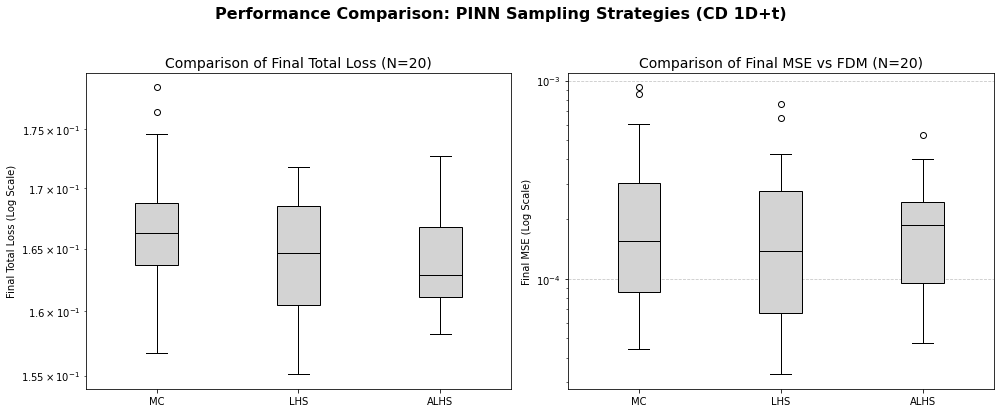

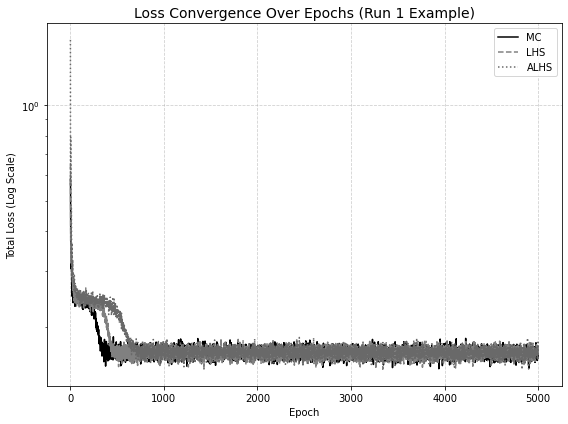


--- Generating Comparison Solution Plot (u(x, t=1.0)) ---


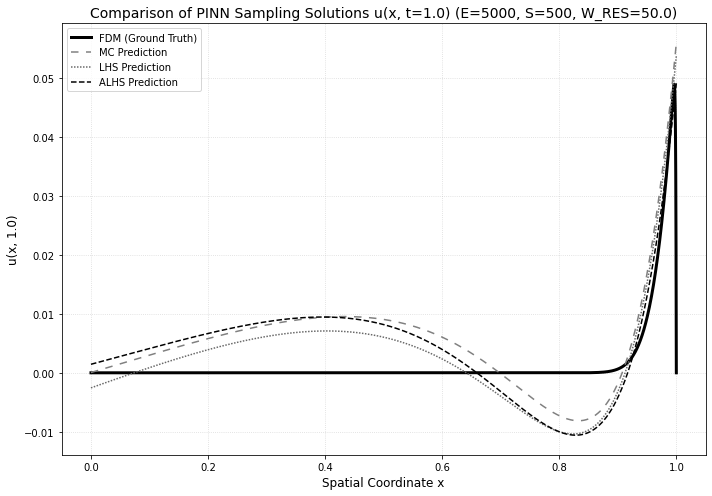

In [2]:
import torch
import torch.nn as nn
import numpy as np
import time
from scipy.stats import qmc
from typing import Tuple, Dict, List, Any
import matplotlib.pyplot as plt

# --- 0. Konfigurasi Global dan Device ---

# Inisialisasi Device Prioritas MPS > CUDA > CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# --- Konfigurasi Eksperimen Default (Untuk Visualisasi Kualitatif) ---
N_RUNS = 20 # Diubah dari 1 (sebelumnya) menjadi 3 agar Box Plot tetap informatif
N_EPOCHS = 5000 
N_SAMPLES = 500    # Sampel Residual (domain interior) per epoch
N_IC_BC = 500      # Sampel untuk IC dan BC per epoch (PENTING: Di-match dengan N_SAMPLES)

# Parameter Persamaan Konveksi-Difusi
C_PARAM = 1.0     # Kecepatan Konveksi
D_PARAM = 0.001   # Koefisien Difusi (Masalah Boundary Layer)

# Pembobotan Loss (Strategi Eksperimen: Lambda_res = 10/50)
W_RES = 50.0
W_IC = 1.0
W_BC = 1.0

# Domain
DOMAIN_X = [0.0, 1.0]
DOMAIN_T = [0.0, 1.0]

# --- 1. Fungsi FDM Implisit (Ground Truth) ---

def solve_convection_diffusion_fdm(L=1.0, T=1.0, nx=2001, nt=50001, c=1.0, D=0.001) -> Tuple[np.ndarray, np.ndarray]:
    """Menghitung solusi referensi FDM Implisit pada t=T."""
    dx = L / (nx - 1)
    dt = T / (nt - 1)
    
    C1 = (c * dt) / (2 * dx)
    C2 = (D * dt) / (dx**2)
    
    # Koefisien Matriks Tridiagonal (Konstan)
    A = - (C1 + C2)
    B = 1 + (2 * C2)
    C_mat = C1 - C2
    
    # Kondisi Awal (IC)
    x = np.linspace(0, L, nx)
    u = np.sin(np.pi * x)
    
    n_interior = nx - 2
    
    # Loop Waktu (Time-Stepping)
    for k in range(1, nt):
        d = np.copy(u[1:-1]) # RHS
        
        # Penyesuaian RHS untuk BC Homogen (tidak ada pengaruh di sini karena u[0]=u[-1]=0)

        p = np.zeros(n_interior)
        q = np.zeros(n_interior)
        
        # TDMA Forward sweep
        p[0] = C_mat / B
        q[0] = d[0] / B
        
        for i in range(1, n_interior):
            den = B - A * p[i-1]
            p[i] = C_mat / den
            q[i] = (d[i] - A * q[i-1]) / den
            
        # TDMA Backward substitution
        u_next_interior = np.zeros(n_interior)
        u_next_interior[-1] = q[-1] 
        
        for i in range(n_interior - 2, -1, -1):
            u_next_interior[i] = q[i] - p[i] * u_next_interior[i+1]
            
        u[1:-1] = u_next_interior
        u[0] = 0.0 # BC
        u[-1] = 0.0 # BC
        
    return x, u 

# --- 2. PINN Model dan Fungsi Sampling Statis/Batas ---

class PINN(nn.Module):
    def __init__(self, layers=[2, 64, 64, 64, 1]):
        super().__init__()
        self.layers = []
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                self.layers.append(nn.Tanh())
        self.net = nn.Sequential(*self.layers).to(device)

    def forward(self, x):
        return self.net(x)

def sample_lhs_2d(n_samples: int, x_min, x_max, t_min, t_max) -> np.ndarray:
    sampler = qmc.Halton(d=2)
    pts = sampler.random(n=n_samples) 
    x_pts = x_min + pts[:, 0] * (x_max - x_min)
    t_pts = t_min + pts[:, 1] * (t_max - t_min)
    return np.hstack([x_pts.reshape(-1,1), t_pts.reshape(-1,1)])

def sample_mc_2d(n_samples: int, x_min, x_max, t_min, t_max) -> np.ndarray:
    x_pts = np.random.uniform(x_min, x_max, n_samples).reshape(-1, 1)
    t_pts = np.random.uniform(t_min, t_max, n_samples).reshape(-1, 1)
    return np.hstack([x_pts, t_pts])

def sample_ic(n_samples: int, x_min, x_max) -> np.ndarray:
    x_pts = np.random.uniform(x_min, x_max, n_samples).reshape(-1, 1)
    t_pts = np.zeros_like(x_pts) 
    return np.hstack([x_pts, t_pts])

def sample_bc(n_samples: int, t_min, t_max) -> np.ndarray:
    n_half = n_samples // 2
    t_pts = np.random.uniform(t_min, t_max, n_samples).reshape(-1, 1)
    
    x_left = np.zeros((n_half, 1))
    t_left = t_pts[:n_half]
    
    x_right = np.ones((n_samples - n_half, 1))
    t_right = t_pts[n_half:]
    
    return np.vstack([np.hstack([x_left, t_left]), np.hstack([x_right, t_right])])

# --- 3. Fungsi Residual dan Adaptive Sampler ---

def residual_CD(model: nn.Module, xt_tensor: torch.Tensor, c_param: float, D_param: float) -> torch.Tensor:
    xt = xt_tensor.clone().detach().requires_grad_(True).to(device)
    
    u = model(xt)
    
    # Turunan Orde Pertama
    grads = torch.autograd.grad(u, xt, torch.ones_like(u), create_graph=True)[0]
    u_x = grads[:, 0]
    u_t = grads[:, 1]
    
    # Turunan Orde Kedua
    u_xx = torch.autograd.grad(u_x, xt, torch.ones_like(u_x), create_graph=True)[0][:, 0]
    
    # Hitung Residual R = u_t + c * u_x - D * u_xx
    res = u_t.view(-1, 1) + c_param * u_x.view(-1, 1) - D_param * u_xx.view(-1, 1)
    return res

class AdaptiveSampler:
    def __init__(self, x_domain, t_domain, alpha=2.0, global_frac=0.6, adapt_interval=20, n_candidate=800):
        self.x_domain = x_domain
        self.t_domain = t_domain
        self.alpha = alpha
        self.global_frac = global_frac
        self.adapt_interval = adapt_interval
        self.n_candidate = n_candidate
        
        # PENTING: Unpacking di sini BENAR karena x_domain dan t_domain adalah list [min, max]
        self.candidate_xt = sample_lhs_2d(n_candidate, *x_domain, *t_domain)
        self.grid_tensor = torch.tensor(self.candidate_xt, dtype=torch.float32, device=device)
        
        self.weights = np.ones(n_candidate) / n_candidate
        self.ema_res = np.zeros(n_candidate)
        
    def update_from_model(self, model, c_param, D_param):
        model.eval()
        res_tensor = residual_CD(model, self.grid_tensor, c_param, D_param)
        res_np = res_tensor.detach().cpu().numpy().flatten() 
        model.train()
        
        self.ema_res = 0.9 * self.ema_res + 0.1 * np.abs(res_np)
        
        P = np.power(self.ema_res, self.alpha)
        self.weights = P / np.sum(P)
        
    def sample_batch(self, n_batch: int) -> np.ndarray:
        n_global = int(n_batch * self.global_frac)
        n_adapt = n_batch - n_global
        
        global_samples = sample_lhs_2d(n_global, *self.x_domain, *self.t_domain)
        
        if n_adapt > 0:
            idx = np.random.choice(self.n_candidate, size=n_adapt, p=self.weights)
            adapt_samples = self.candidate_xt[idx]
            return np.vstack([global_samples, adapt_samples])
        else:
            return global_samples

# --- 4. Fungsi Pelatihan Utama ---

# Target IC
TARGET_IC_VAL = lambda x: np.sin(np.pi * x) 

def train_single_run(model, method: str, epochs: int, n_samples: int, n_ic_bc: int, c_param: float, D_param: float, sampler_alhs=None):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    start_time = time.time()
    history = {'loss': [], 'time': []}
    
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        
        # 1. SAMPLING DATA
        if method == 'alhs' and sampler_alhs and epoch % sampler_alhs.adapt_interval != 0:
            Xt_res_np = sampler_alhs.sample_batch(n_samples)
        elif method == 'alhs' and sampler_alhs and epoch % sampler_alhs.adapt_interval == 0:
            Xt_res_np = sampler_alhs.sample_batch(n_samples) 
            sampler_alhs.update_from_model(model, c_param, D_PARAM) # Pindahkan Adaptasi di sini
        elif method == 'mc':
            Xt_res_np = sample_mc_2d(n_samples, *DOMAIN_X, *DOMAIN_T)
        elif method == 'lhs':
            Xt_res_np = sample_lhs_2d(n_samples, *DOMAIN_X, *DOMAIN_T)
        else:
            Xt_res_np = sample_mc_2d(n_samples, *DOMAIN_X, *DOMAIN_T)
            
        Xt_ic_np = sample_ic(n_ic_bc, *DOMAIN_X)
        Xt_bc_np = sample_bc(n_ic_bc, *DOMAIN_T)
        
        Xt_res_t = torch.tensor(Xt_res_np, dtype=torch.float32, device=device)
        Xt_ic_t = torch.tensor(Xt_ic_np, dtype=torch.float32, device=device)
        Xt_bc_t = torch.tensor(Xt_bc_np, dtype=torch.float32, device=device)
        
        # 2. PERHITUNGAN LOSS
        loss_res = torch.mean(residual_CD(model, Xt_res_t, c_param, D_param)**2)
        
        u_ic_pred = model(Xt_ic_t)
        u_ic_true = torch.tensor(TARGET_IC_VAL(Xt_ic_np[:, 0]), dtype=torch.float32, device=device).view(-1, 1)
        loss_ic = torch.mean((u_ic_pred - u_ic_true)**2)
        
        u_bc_pred = model(Xt_bc_t)
        loss_bc = torch.mean(u_bc_pred**2) # Target BC = 0.0
        
        # Total Loss DENGAN Bobot Residual W_RES=10.0
        total_loss = (W_RES * loss_res) + (W_IC * loss_ic) + (W_BC * loss_bc)
        
        # 3. BACKPROPAGATION
        total_loss.backward()
        optimizer.step()
        
        # 4. ALHS ADAPTATION (Sudah dipindahkan ke bagian sampling)
        
        history['loss'].append(total_loss.item())
        history['time'].append(time.time() - start_time)
        
    return history

# --- 5. Fungsi Evaluasi MSE dan Eksperimen ---

def calculate_final_mse(model: nn.Module, x_ref: np.ndarray, u_ref_final: np.ndarray) -> float:
    """Menghitung Final MSE (t=1.0) vs Solusi FDM."""
    
    # Grid Pengujian PINN (t=1.0)
    x_test_np = x_ref.reshape(-1, 1)
    t_test_np = np.ones_like(x_test_np) * 1.0 
    xt_test_np = np.hstack([x_test_np, t_test_np])
    
    xt_test_t = torch.tensor(xt_test_np, dtype=torch.float32, device=device)
    
    model.eval()
    with torch.no_grad():
        u_pinn_pred = model(xt_test_t).cpu().numpy().flatten()
    model.train()
        
    u_ref = u_ref_final.flatten()
    mse = np.mean((u_pinn_pred - u_ref)**2)
    return mse


def run_experiments(methods: List[str], x_ref: np.ndarray, u_ref_final: np.ndarray, n_runs: int) -> Dict[str, List[Dict[str, Any]]]:
    
    results = {m: [] for m in methods}
    
    for m in methods:
        print(f"\n--- Starting Method: {m.upper()} on {device} (N_EPOCHS={N_EPOCHS}, N_SAMPLES={N_SAMPLES}, W_RES={W_RES}) ---")
        
        # PERBAIKAN: Menggunakan AdaptiveSampler(DOMAIN_X, DOMAIN_T) yang sudah benar
        sampler = AdaptiveSampler(DOMAIN_X, DOMAIN_T) if m == 'alhs' else None
        
        for i in range(n_runs):
            model = PINN().to(device)
            
            # --- PENTING: N_SAMPLES dan N_IC_BC menggunakan nilai global yang besar (500) ---
            history = train_single_run(
                model=model, method=m, epochs=N_EPOCHS, n_samples=N_SAMPLES, n_ic_bc=N_IC_BC,
                c_param=C_PARAM, D_param=D_PARAM, sampler_alhs=sampler if m == 'alhs' else None
            )
            
            # Evaluasi Kinerja Fisika
            final_mse = calculate_final_mse(model, x_ref, u_ref_final)
            
            # Menyimpan model (state_dict) untuk visualisasi kualitatif terbaik
            is_best = (final_mse == min([r['final_mse'] for r in results[m]] + [final_mse]))
            
            results[m].append({
                'final_loss': history['loss'][-1],
                'final_mse': final_mse,
                'time': history['time'][-1],
                'history': history,
                'model_state': model.state_dict() if is_best or n_runs==1 else None # Simpan hanya yang terbaik / jika N_RUNS=1
            })
            print(f"Run {i+1}/{n_runs} finished. Loss: {history['loss'][-1]:.3e}, MSE: {final_mse:.3e}, Time: {history['time'][-1]:.2f}s {'(Best Model Saved)' if is_best or n_runs==1 else ''}")
    return results

# --- 6. FUNGSI VISUALISASI ---

def plot_results(results: Dict[str, List[Dict[str, Any]]], n_runs: int):
    # ... (Fungsi plot_results yang sudah Anda berikan untuk Box Plot dan Loss Convergence) ...
    
    # [Box Plot dan Loss Convergence Plot dimasukkan di sini, sama seperti yang Anda berikan sebelumnya]
    
    methods = list(results.keys())
    
    # 1. Persiapan Data untuk Box Plot
    final_losses = [np.array([r['final_loss'] for r in results[m]]) for m in methods]
    final_mses = [np.array([r['final_mse'] for r in results[m]]) for m in methods]
    
    labels = [m.upper() for m in methods]
    
    # --- Plotting ---
    
    # 1. Box Plot Final Loss dan Final MSE
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Final Loss Plot
    ax[0].boxplot(final_losses, patch_artist=True, labels=labels, 
                           boxprops=dict(facecolor='lightgray', color='black'),
                           medianprops=dict(color='black'),
                           whiskerprops=dict(color='black'),
                           capprops=dict(color='black'))
    
    ax[0].set_title(f'Comparison of Final Total Loss (N={n_runs})', fontsize=14)
    ax[0].set_ylabel('Final Total Loss (Log Scale)')
    ax[0].set_yscale('log')
    ax[0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Final MSE Plot
    ax[1].boxplot(final_mses, patch_artist=True, labels=labels,
                          boxprops=dict(facecolor='lightgray', color='black'),
                          medianprops=dict(color='black'),
                          whiskerprops=dict(color='black'),
                          capprops=dict(color='black'))
                          
    ax[1].set_title(f'Comparison of Final MSE vs FDM (N={n_runs})', fontsize=14)
    ax[1].set_ylabel('Final MSE (Log Scale)')
    ax[1].set_yscale('log')
    ax[1].grid(axis='y', linestyle='--', alpha=0.7)
    
    fig.suptitle('Performance Comparison: PINN Sampling Strategies (CD 1D+t)', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'performance_box_wres{W_RES}_nruns{N_RUNS}_S={N_SAMPLES}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    # --- Plot Konvergensi ---
    
    # Ambil sejarah dari run pertama (Run 1) sebagai representasi
    plt.figure(figsize=(8, 6))
    
    mc_hist = results['mc'][0]['history']['loss']
    lhs_hist = results['lhs'][0]['history']['loss']
    alhs_hist = results['alhs'][0]['history']['loss']
    
    epochs = np.arange(1, len(mc_hist) + 1)
    
    plt.plot(epochs, mc_hist, label='MC', linestyle='-', color='black')
    plt.plot(epochs, lhs_hist, label='LHS', linestyle='--', color='gray')
    plt.plot(epochs, alhs_hist, label='ALHS', linestyle=':', color='dimgray')
    
    plt.title('Loss Convergence Over Epochs (Run 1 Example)', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss (Log Scale)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f'los_convergence_wres{W_RES}_nruns{N_RUNS}_S={N_SAMPLES}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

def plot_comparison_solutions(trained_models: Dict[str, nn.Module], x_ref: np.ndarray, u_ref_final: np.ndarray):
    """
    Membuat plot perbandingan solusi u(x, t=1.0) dari MC, LHS, dan ALHS 
    terhadap Ground Truth FDM dalam satu bingkai.
    """
    plt.figure(figsize=(10, 7))
    
    # 1. Plot FDM (Ground Truth)
    plt.plot(x_ref, u_ref_final, 
             label='FDM (Ground Truth)', 
             color='black', linewidth=3, linestyle='-')

    # Ambil device dari parameter pertama model (Perbaikan Error)
    first_model = trained_models[list(trained_models.keys())[0]]
    model_device = next(iter(first_model.parameters())).device 

    # Grid pada t=1.0
    xt_test_t_final = torch.tensor(
        np.hstack([x_ref.reshape(-1, 1), np.ones_like(x_ref).reshape(-1, 1)]), 
        dtype=torch.float32, 
        device=model_device
    )
    
    # 2. Plot Prediksi PINN (MC, LHS, ALHS)
    plot_styles = {
        'mc': {'color': 'gray', 'linestyle': (0, (5, 5)), 'label': 'MC Prediction'}, 
        'lhs': {'color': 'dimgray', 'linestyle': (0, (1, 1)), 'label': 'LHS Prediction'}, 
        'alhs': {'color': 'black', 'linestyle': '--', 'label': 'ALHS Prediction'}, 
    }
    
    for method, model in trained_models.items():
        model.eval()
        with torch.no_grad():
            u_pinn = model(xt_test_t_final).cpu().numpy().flatten()
        
        style = plot_styles[method]
        
        plt.plot(x_ref, u_pinn, 
                 label=style['label'], 
                 color=style['color'], 
                 linewidth=1.5, 
                 linestyle=style['linestyle'])
    
    plt.title(f'Comparison of PINN Sampling Solutions u(x, t=1.0) (E={N_EPOCHS}, S={N_SAMPLES}, W_RES={W_RES})', fontsize=14)
    plt.xlabel('Spatial Coordinate x', fontsize=12)
    plt.ylabel('u(x, 1.0)', fontsize=12)
    plt.legend(loc='upper left', frameon=True)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f'solution_comparison_wres{W_RES}_nruns{N_RUNS}_S={N_SAMPLES}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

# --- 7. Eksekusi Utama dan Analisis ---

if __name__ == "__main__":
    
    # 1. Hitung Solusi FDM (Ground Truth)
    NX_REF = 2001 
    NT_REF = 50001
    print(f"Menggunakan device: {device}")
    print(f"Konfigurasi Eksperimen: E={N_EPOCHS}, S={N_SAMPLES}, IC/BC={N_IC_BC}, Runs={N_RUNS}")
    print(f"Menghitung solusi referensi FDM ({NX_REF}x{NT_REF})...")
    
    start_time_fdm = time.time()
    x_ref, u_ref_final = solve_convection_diffusion_fdm(
        nx=NX_REF, nt=NT_REF, D=D_PARAM
    )
    time_fdm = time.time() - start_time_fdm
    print(f"FDM Selesai dalam {time_fdm:.2f} detik. Mulai PINN Eksperimen...")

    # 2. Jalankan Eksperimen PINN (N_RUNS Statistik)
    methods = ('mc', 'lhs', 'alhs')
    results = run_experiments(methods=methods, x_ref=x_ref, u_ref_final=u_ref_final, n_runs=N_RUNS)

    # 3. Analisis dan Ringkasan Hasil
    print("\n" + "="*40)
    print("      SUMMARY OF FINAL RESULTS")
    print("="*40)
    
    for m in methods:
        mses = np.array([r['final_mse'] for r in results[m]])
        losses = np.array([r['final_loss'] for r in results[m]])
        times = np.array([r['time'] for r in results[m]])
        
        print(f"\nMethod: {m.upper()} (N_RUNS={N_RUNS})")
        print(f"Mean Final MSE (vs FDM): {np.mean(mses):.3e}, Std: {np.std(mses):.3e}")
        print(f"Mean Final Loss (PINN): {np.mean(losses):.3e}, Std: {np.std(losses):.3e}")
        print(f"Mean Time: {np.mean(times):.2f}s, Std: {np.std(times):.2f}s")

    # 4. Visualisasi Metrik (Box Plot & Konvergensi)
    print("\n--- Generating Metric Visualizations (Box Plot & Loss Convergence) ---")
    plot_results(results, N_RUNS)

    # 5. Visualisasi Kualitatif (Solution Comparison Plot)
    
    # Kumpulkan model terbaik/representatif dari hasil run (kita simpan state_dict model terbaik)
    trained_models_for_plot = {}
    
    for m in methods:
        # Cari hasil dengan MSE terendah (model terbaik)
        best_result = min(results[m], key=lambda x: x['final_mse'])
        
        # Inisialisasi model baru dan muat state_dict terbaik
        model_best = PINN().to(device)
        model_best.load_state_dict(best_result['model_state'])
        trained_models_for_plot[m] = model_best

    print("\n--- Generating Comparison Solution Plot (u(x, t=1.0)) ---")
    plot_comparison_solutions(trained_models_for_plot, x_ref, u_ref_final)